In [13]:
import numpy as np
import pyintersection as pyi
import matplotlib.pyplot as plt

# Define some help functions

## Define plot functions

In [3]:
def plot_rpoints(axis, rpoints, c=None, s=None, **kwargs):
    ix, iy, iz = rpoints[:, 4:5], rpoints[:, 5:6], rpoints[:, 6:7]
    axis.scatter(ix, iy, iz, c=c, s=s, **kwargs)
    
def plot_mpoints(axis, mpoints, c=None, s=None, **kwargs):
    ix, iy, iz = mpoints[:, 2:3], mpoints[:, 3:4], mpoints[:, 4:5]
    axis.scatter(ix, iy, iz, c=c, s=s, **kwargs)
    
def plot_rawpoints(axis, points, c=None, s=None, **kwargs):
    ix, iy, iz = points[:, 0:1], points[:, 1:2], points[:, 2:3]
    axis.scatter(ix, iy, iz, c=c, s=s, **kwargs)
    
def plot_surface(axis, mesh, **kwargs):
    ix, iy, iz = mesh
    axis.plot_surface(ix, iy, iz, **kwargs)

## Define plaine create mesh function

In [4]:
def create_plain_mesh(n, D=0, L=7, W=7):
    kx, ky = 31, 31
 
    n = n / np.linalg.norm(n)
    x, y = np.mgrid[-L:L:kx*1j, -W:W:ky*1j]
    A, B, C = n
    z = -(A*x+B*y+D)/C
    return (x, y, z)

## Define manifold and point generator functions

In [5]:
def create_manifold_generator(generate_point=None, points_count=40):
    scaling = 1
    def generator(n, t, atol, points_count=points_count):
        size = int(points_count**0.5)
        twidth = atol * scaling
        nwidth = atol * scaling
        ts = np.linspace(t - twidth / 2, t + twidth / 2, size)
        ns = np.linspace(n - nwidth / 2, n + nwidth / 2, size)
        res = np.zeros((len(ns) * len(ts), 5))

        for i, n in enumerate(ns):
            for j, t in enumerate(ts):
                res[j + len(ts) * i] = n, t, *generate_point(n, t)
        return res
    return generator

def create_point_generator(vec_par, vec_offset):
    def generator(n, t):
        return vec_offset * n + vec_par * t
    return generator

## Create mesh, point and manifold generators

In [6]:
### Generator for first plain or "A" manifold
a_norm = np.array([1, 1, 1]) # Norm vector of the plane
a_par = np.array([1, -0.5, -0.5]) # Some orthogonal to norm vector
a_offset = np.array([0, 1, -1]) # One another orthogonal to previous other vectors
a_point_generator = create_point_generator(a_par, a_offset)
a_manifold_generator = create_manifold_generator(a_point_generator)
a_plain_mesh = create_plain_mesh(a_norm, L=4, W=4)

### Generator for second plain or "B" manifold
b_norm = np.array([1, 0, 1]) # Norm vector of the plane
b_par = np.array([1, 0, -1]) # Some orthogonal to norm vector
b_offset = np.array([0, 1, 0]) # One another orthogonal to previous other vectors
b_point_generator = create_point_generator(b_par, b_offset)
b_manifold_generator = create_manifold_generator(b_point_generator)
b_plain_mesh = create_plain_mesh(b_norm, L=4, W=4)

# 1. Find intersection

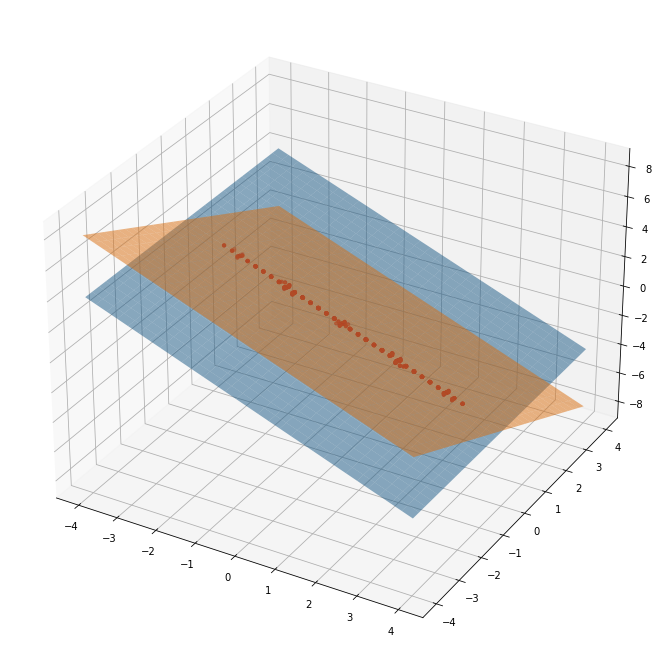

In [7]:
a = a_manifold_generator(0, 0, 4)
b = b_manifold_generator(0, 0, 4)

_, rpoints, _ = pyi.optimize3d(a, b, 0.1, a_manifold_generator, b_manifold_generator, max_iter=3)

fig = plt.figure(figsize=(12, 12))
axis = fig.add_subplot(111, projection='3d')
# Plot surfaces for two planes
plot_surface(axis, b_plain_mesh, alpha=0.5)
plot_surface(axis, a_plain_mesh, alpha=0.5)
# Plot points form intersection
plot_rpoints(axis, rpoints, c='r', s=10)

# 2. Build approximate intersection curve

## 2.1 Define help approximate functions

In [14]:
def mfilter(arr, m):
    return np.array([*filter(lambda x: x[0] == m, arr)])

def rpoints_t_from_n(rpoints, m):
    # m n t
    mnt = rpoints[:, 1:4]
    # n t
    nt = mfilter(mnt, m)[:, 1:]
    # sorted nt
    nt = np.array(sorted(nt, key=lambda x: x[0]))
    n = nt[:, 0]
    t = nt[:, 1]
    return n, t

def rpoints_n_from_t(rpoints, m):
    # m n t
    mnt = rpoints[:, 1:4]
    # n t
    nt = mfilter(mnt, m)[:, 1:]
    # sorted nt
    nt = np.array(sorted(nt, key=lambda x: x[1]))
    n = nt[:, 0]
    t = nt[:, 1]
    return t, n

def spline(x, y, deg=2):
    coefs = np.polyfit(x, y, deg)
    return np.polynomial.Polynomial(coefs)

## 2.2 Plot approximate functions

### 2.2.1 Approximate intersection using a-manifold points n(t)

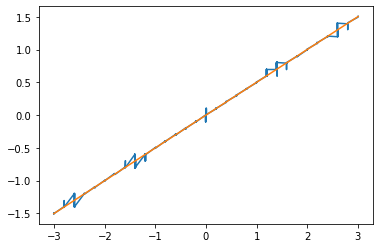

In [15]:
t0, n0 = rpoints_n_from_t(rpoints, 0)
n_from_t0 = spline(t0, n0)
plt.plot(t0, n0)
plt.plot(t0, n_from_t0(t0))

### 2.2.2 Approximate intersection using a-manifold points n(t)

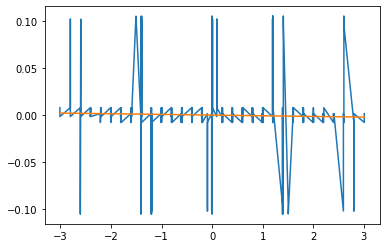

In [16]:
t1, n1 = rpoints_n_from_t(rpoints, 1)
n_from_t1 = spline(t1, n1)
plt.plot(t1, n1)
plt.plot(t1, n_from_t1(t1))

# 3. Plot intersection using approximate functions

## 3.1 Plot intersection using a-manifold n(t) approximate function

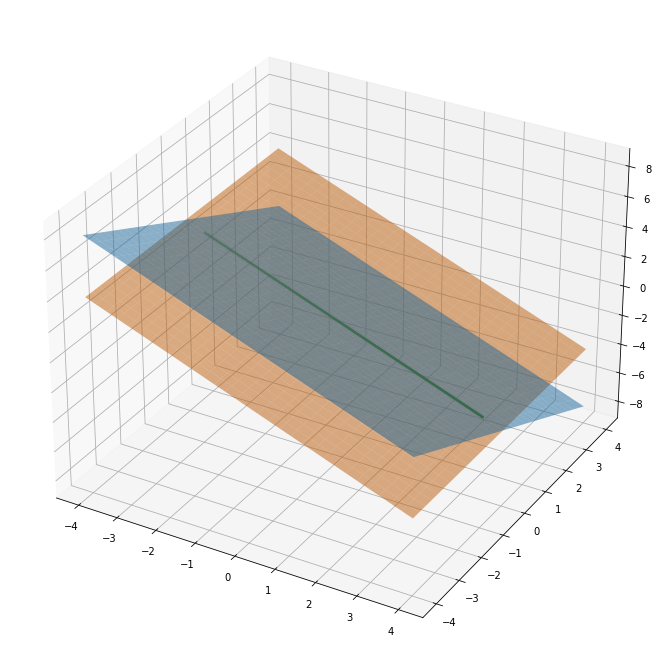

In [21]:
# Generate points
ts = np.linspace(-3.5, 3.5, 200)
points = np.array([a_point_generator(n_from_t0(t), t) for t in ts])

# Plot results
fig = plt.figure(figsize=(12, 12))
axis = fig.add_subplot(111, projection='3d')
plot_surface(axis, a_plain_mesh, alpha=0.5)
plot_surface(axis, b_plain_mesh, alpha=0.5)
plot_rawpoints(axis, points, c='g', s=4)

## 3.2 Plot intersection using b-manifold n(t) approximate function

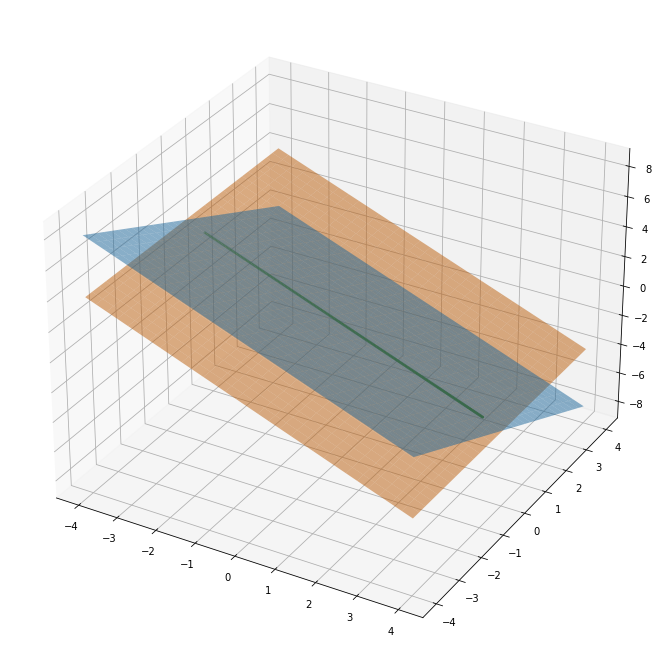

In [20]:
# Generate points
ts = np.linspace(-3.5, 3.5, 200)
points = np.array([b_point_generator(n_from_t1(t), t) for t in ts])

# Plot results
fig = plt.figure(figsize=(12, 12))
axis = fig.add_subplot(111, projection='3d')
plot_surface(axis, a_plain_mesh, alpha=0.5)
plot_surface(axis, b_plain_mesh, alpha=0.5)
plot_rawpoints(axis, points, c='g', s=4)